In [1]:
import numpy as np

# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, transpile, Aer, IBMQ
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, execute, Aer
from qiskit.tools.jupyter import *
from qiskit.visualization import *
# from qiskit.providers.aer import QasmSimulator

import bitarray
from bitstring import Bits

Check whether $a-b \lt 0$ or $a-b \geq 0$. This can be done by examining the flag bit in the $a-b$ operation

x: 000111
y: 001010
{'1 110110': 1024}
10


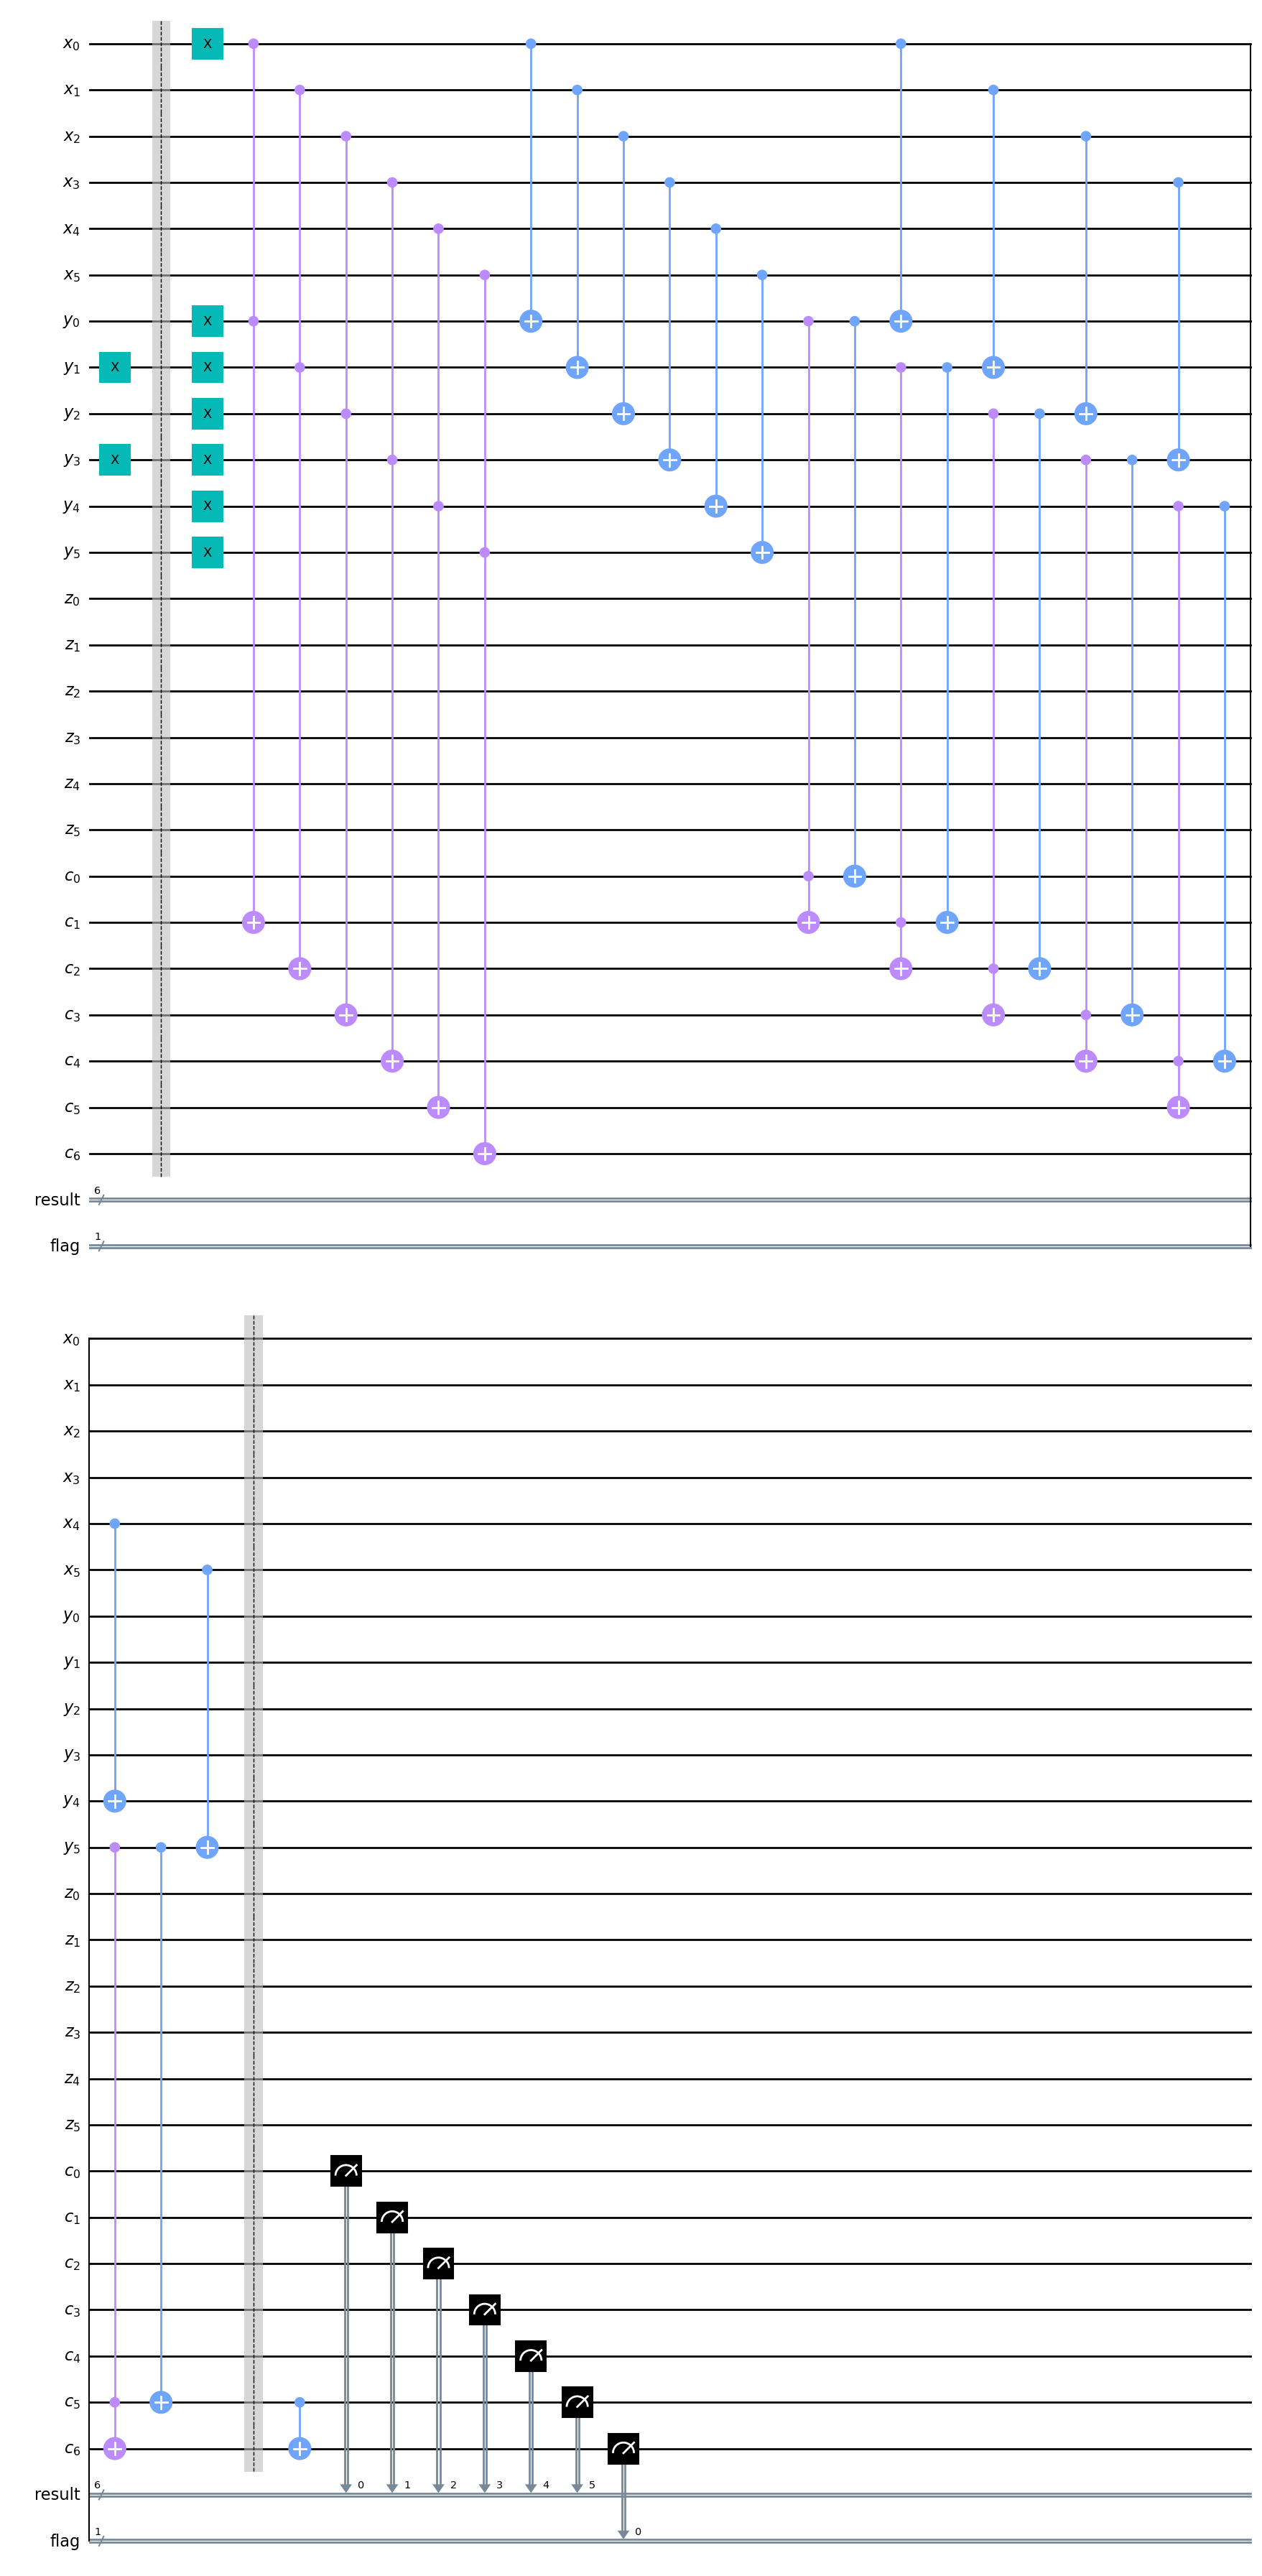

In [2]:
def find_the_largest_number(number_1, number_2):    
    # Define the number of qubits in each register
    n = 6

    # Create a Quantum Register with n qubits
    num1 = QuantumRegister(n, 'x')
    num2 = QuantumRegister(n, 'y')
    sum_ = QuantumRegister(n, "z")
    carry = QuantumRegister(n+1, 'c')

    # Create a Classical Register with n qubits
    result = ClassicalRegister(n, 'result')
    flag = ClassicalRegister(1, 'flag')

    # Create the quantum circuit
    qc = QuantumCircuit()
    qc.add_register(num1)
    qc.add_register(num2)
    qc.add_register(sum_)
    qc.add_register(carry)
    qc.add_register(result)
    qc.add_register(flag)

    # init number
    x = Bits(int=number_1, length=n)
    y = Bits(int=number_2, length=n)
    print("x:", x.bin)
    print("y:", y.bin)
    
    # for i, bit in enumerate(x.bin[::-1]):
    #     if bit == "1":
    #         qc.x(num1[i])
    
    for i, bit in enumerate(y.bin[::-1]):
        if bit == "1":
            qc.x(num2[i])

    # Transform num2 to 2's complement
    qc.barrier()

    # Flip qubits
    for i in range(n):
        qc.x(num2[i])

    # Add 1
    # for i in range(n-1, 0, -1):
    #     qc.cx(num2[i-1], num2[i])
    # qc.x(num2[0])

    # for i in range(n-2):
    #     qc.ccx(num2[i], num2[i+1], num2[i+2])
    qc.x(num1[0])
    for i in range(n):
        qc.ccx(num1[i], num2[i], carry[i+1])
        qc.cx(num1[i], num2[i])
        qc.ccx(num2[i], carry[i], carry[i+1])
        qc.cx(num2[i], carry[i])
        qc.cx(num1[i], num2[i])
    # end 2's complement transform

    qc.barrier()

    # Add num1 and num2
    # for i in range(n):
    #     qc.ccx(num1[i], num2[i], carry[i+1])
    #     qc.cx(num1[i], num2[i])
    #     qc.ccx(num2[i], carry[i], carry[i+1])
    #     qc.cx(num2[i], carry[i])
    #     qc.cx(num1[i], num2[i])

    # overflow flag
    qc.cx(carry[n-1], carry[n])
    # for i in range(n):
    #     qc.measure(num2[i], result[i])
    for i in range(n):
        qc.measure(carry[i], result[i])
    qc.measure(carry[n], flag)

    # Simulate the circuit to obtain the measurement results
    backend = Aer.get_backend('qasm_simulator')
    job = execute(qc, backend, shots=1024)
    result = job.result()
    counts = result.get_counts(qc)

    # Print the measurement results
    print(counts)
    flags = counts.most_frequent().split()

    if flags[1][0] == "1":
        print(number_2)
    else:
        print(number_1)

    return qc.draw("mpl")

find_the_largest_number(7, 10)

x: 101111
y: 001010
GAS
{'0 100101': 3}
10


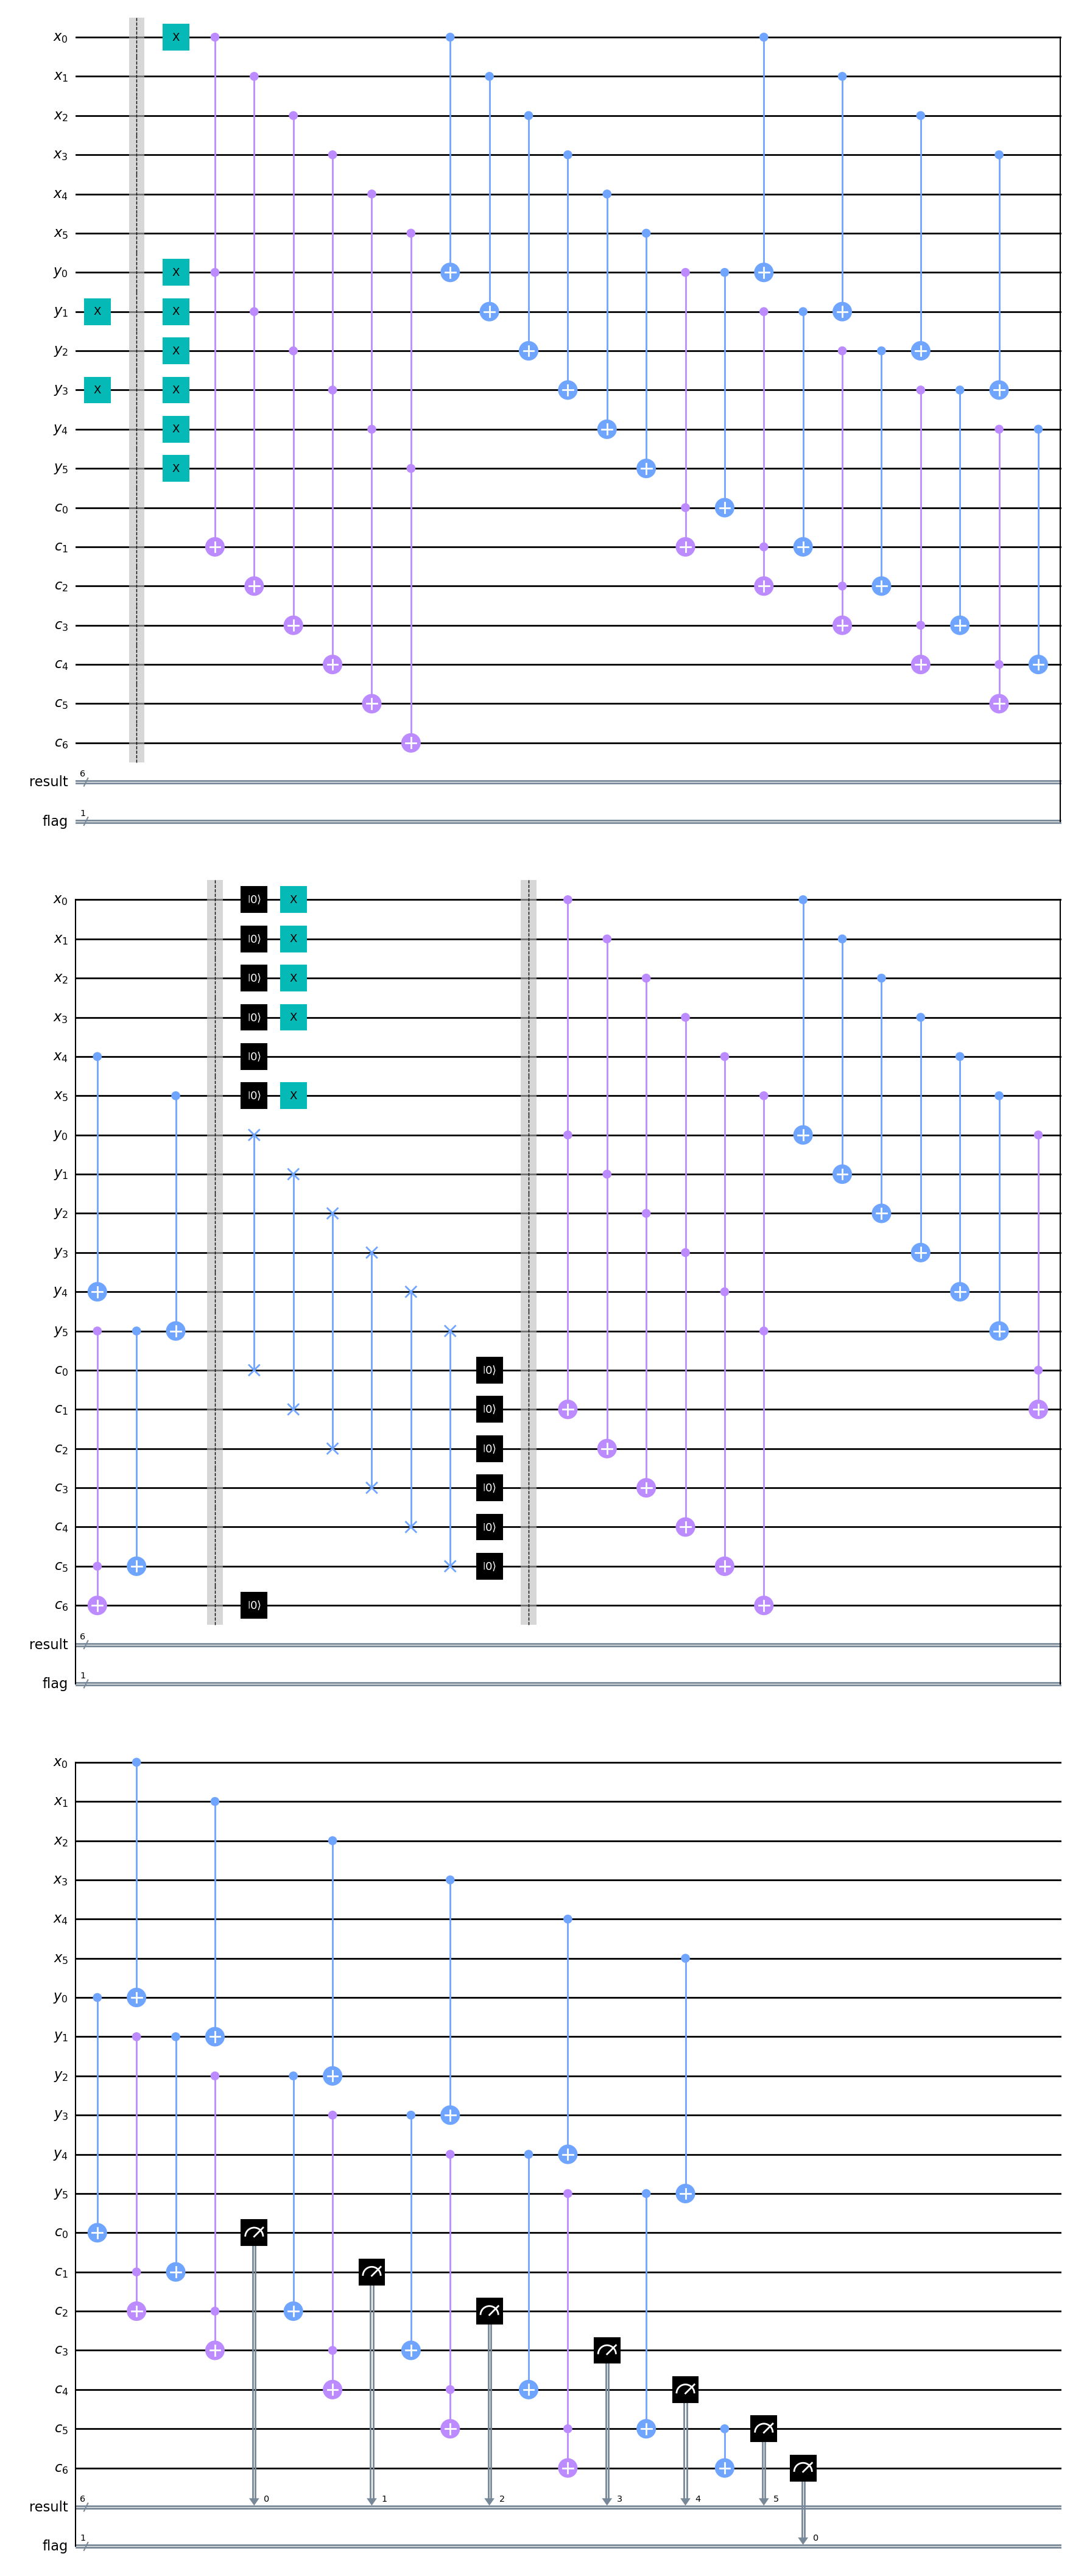

In [7]:
def find_the_largest_number(number_1, number_2):    
    # Define the number of qubits in each register
    n = 6

    # Create a Quantum Register with n qubits
    num1 = QuantumRegister(n, 'x')
    num2 = QuantumRegister(n, 'y')
    carry = QuantumRegister(n+1, 'c')

    # Create a Classical Register with n qubits
    result = ClassicalRegister(n, 'result')
    flag = ClassicalRegister(1, 'flag')

    # Create the quantum circuit
    qc = QuantumCircuit()
    qc.add_register(num1)
    qc.add_register(num2)
    # qc.add_register(sum_)
    qc.add_register(carry)
    qc.add_register(result)
    qc.add_register(flag)

    # init number
    x = Bits(int=number_1, length=n)
    y = Bits(int=number_2, length=n)
    print("x:", x.bin)
    print("y:", y.bin)
    
    for i, bit in enumerate(y.bin[::-1]):
        if bit == "1":
            qc.x(num2[i])

    # Transform num2 to 2's complement
    qc.barrier()

    # Flip qubits
    for i in range(n):
        qc.x(num2[i])

    # Add 1
    qc.x(num1[0])
    for i in range(n):
        qc.ccx(num1[i], num2[i], carry[i+1])
        qc.cx(num1[i], num2[i])
        qc.ccx(num2[i], carry[i], carry[i+1])
        qc.cx(num2[i], carry[i])
        qc.cx(num1[i], num2[i])
    # end 2's complement transform

    qc.barrier()
    
    # reset
    for i in range(n):
        qc.swap(num2[i], carry[i])

    for i in range(n):
        qc.reset(num1[i])
        qc.reset(carry[i])

    for i, bit in enumerate(x.bin[::-1]):
        if bit == "1":
            qc.x(num1[i])

    qc.reset(carry[n])
    
    qc.barrier()
    # Add num1 and num2
    for i in range(n):
        qc.ccx(num1[i], num2[i], carry[i+1])
        qc.cx(num1[i], num2[i])
        qc.ccx(num2[i], carry[i], carry[i+1])
        qc.cx(num2[i], carry[i])
        qc.cx(num1[i], num2[i])

    # overflow flag
    qc.cx(carry[n-1], carry[n])
    # for i in range(n):
    #     qc.measure(num2[i], result[i])
    for i in range(n):
        qc.measure(carry[i], result[i])
    qc.measure(carry[n], flag)

    # Simulate the circuit to obtain the measurement results
    backend = Aer.get_backend('qasm_simulator')
    job = execute(qc, backend, shots=3)
    result = job.result()
    counts = result.get_counts(qc)

    # Print the measurement results
    print(counts)
    flags = counts.most_frequent().split()

    if flags[1][0] == "1":
        print(number_2)
    else:
        print(number_1)

    return qc.draw("mpl")

find_the_largest_number(-17, 10)